# Random Coefficients Logit Demand Model

### Econometrics B (ØkB)

**Bertel Schjerning**  
Department of Economics, University of Copenhagen  

### Readings:
- **Conlon & Gortmaker (2020).** ["Best Practices for Differentiated Products Demand Estimation with PyBLP."](https://doi.org/10.1111/1756-2171.12352) *RAND Journal of Economics*, 51(4), 1108–1161.

### More readings
  3. **B**erry, **L**evinsohn, & **P**akes (1995) - BLP demand model
  4. Nevo (2000) - A practitioner's guide to random coefficients logit
  5. Petrin (2002) - Quantifying benefits of new products
  6. Berry, Levinsohn, & Pakes (2004) - Micro and macro data in demand estimation
  1. Berry & Haile (2021) - Foundations of demand estimation
  2. Conlon & Gortmaker (2025) - Incorporating microdata into BLP with PyBLP

None of these are required but are recommended for further study. See full refeference list at last slide 



## **Part 1**: OLS and IV estimation of logit demand model with $\mu_{ijt}=0$
$$
            \log\frac{s_{jt}}{s_{0t}} = \delta_{jt} = \alpha p_{jt} + x_{jt}'\beta + \xi_{jt}
$$

## Initial setup of libraries

In [1]:
# For debugging
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import mymlr as mlr
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time
# Matrix inversion shorthand
inv = np.linalg.inv


# Set up the display settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.float_format', '{:g}'.format)

## Read the data from and Greico et al. (2024) and create variables

In [2]:
# Load data and add constant
df = pd.read_csv("cars.csv")
df["const"] = 1  

# Compute market shares and outside good share
df["s_jt"] = df["sales"] / (df["number_households"] / 2.5)
df["s_0t"] = 1 - df.groupby("year")["s_jt"].transform("sum")

# Log-difference of shares
df["dlogs_jt"] = np.log(df["s_jt"]) - np.log(df["s_0t"])

# Create dummies (drop reference categories)
year_dummies = pd.get_dummies(df["year"], prefix="y").drop(columns="y_1980", errors="ignore")
make_dummies = pd.get_dummies(df["make"]).drop(columns="volvo", errors="ignore")
df = pd.concat([df, year_dummies, make_dummies], axis=1)

# Dummy variable groups
D_year, D_make = year_dummies.columns.tolist(), make_dummies.columns.tolist()
D_type = ["sport", "EV", "truck", "suv", "van"]

# Log-transform selected variables
X_var = ["height", "hp", "mpg", "weight", "footprint", "number_trims"]
df[[f"log_{x}" for x in X_var]] = np.log(df[X_var])
X_var = [f"log_{x}" for x in X_var] + ["releaseYear", "yearsSinceDesign"]

## Estimation using OLS and IV

In [3]:
# Define LHS variable
delta = df["dlogs_jt"]
# Define RHS variable sets
c = df[["const"]]
X_sets = [
    c, 
    df[["const"] + X_var], 
    df[["const"] + X_var + D_type], 
    df[["const"] + X_var + D_type + D_year], 
    df[["const"] + X_var + D_type + D_year + D_make]
]
# Run OLS regressions
results = [mlr.ols(delta, pd.concat([X1, df["price"]], axis=1), robust=True) for X1 in X_sets]
# Run IV regression
results.append(mlr.tsls(y=delta, X1=X_sets[-1], X2=df["price"], Ze=df["RXR"], robust=True))
# Regression summary
column_titles = ["p", "p+X", "p+X+t", "p+X+t+y", "p+X+t+y+m", "p+X+t+y+m (IV)"]
mlr.summary(results, column_titles=column_titles, print_regressors=["price"] + X_var)

                            p        p+X      p+X+t    p+X+t+y  p+X+t+y+m p+X+t+y+m (IV)
Dependent variable [dlogs_jt] [dlogs_jt] [dlogs_jt] [dlogs_jt] [dlogs_jt]     [dlogs_jt]
             price    -0.0373    -0.0203    -0.0179    -0.0298    -0.0337        -0.1694
                     (0.0010)   (0.0014)   (0.0014)   (0.0014)   (0.0017)       (0.0269)
        log_height               -0.8774    -2.2726    -1.2168    -0.8707        -3.1315
                                (0.2059)   (0.2864)   (0.2824)   (0.2723)       (0.5682)
            log_hp               -1.2029    -1.2179     0.4285     0.3750         2.6639
                                (0.0666)   (0.0679)   (0.1049)   (0.1012)       (0.4801)
           log_mpg               -1.3059    -1.2027     0.3280    -0.1240         0.5428
                                (0.0834)   (0.0883)   (0.1218)   (0.1139)       (0.2002)
        log_weight               -1.0178    -1.5160    -0.8093    -0.9774         3.7059
                     

## **Part 2**:  Solve for $\delta$ using the BLP contraction when $\mu_{ijt}=0$ and compare to $\log(\hat{s}_{jt}/\hat{s}_{0t})$
**BLP Contraction iteration:**
$$
\delta_{jt}^{k+1} = \delta_{jt}^{k} + \log(\hat{s}_{jt}) - \log(s_{jt}(\delta^k))
$$
where $s_{jt}(\delta^k)$ is computed using the logit choice probabilities.

## Let's first implement the logit ccp's


In [4]:
def logit(v, sigma=1, v0=None):
    """
    Compute logit choice probabilities.

    Parameters:
        v : ndarray (N x J)
            Utility levels for J alternatives across N repetitions (individuals or draws).
        sigma : float
            Scale parameter (default is 1).
        v0 : float or ndarray (N x 1), optional
            Utility of the outside good. Can be a scalar or (N x 1) array.

    Returns:
        p : ndarray (N x J)
            Logit probabilities for each alternative.
    """
    max_v = np.max(v, axis=1, keepdims=True)  # (N x 1) for numerical stability
    exp_v = np.exp((v - max_v) / sigma)  # (N x J), safe exponentiation

    # Compute denominator (sum over all alternatives)
    sumexp = np.sum(exp_v, axis=1, keepdims=True)  # (N x 1)
    
    # Add outside good if provided
    if v0 is not None:
        v0 = np.array(v0).reshape(-1, 1)  # Ensure (N x 1) shape if not scalar
        sumexp += np.exp((v0 - max_v) / sigma)  # Add exp(v0)

    return exp_v / sumexp  # (N x J) matrix of probabilities

## Predicted market shares in the data given $\delta$


In [5]:
# Compute conditional choice probabilities (CCP) in the data
def predicted_share_logit(df, delta):
    N = len(df)  # Number of observations
    ccp_jt = np.zeros((N, 1))  # (N x 1)

    years = df["year"].unique() 
    for year in years:
        iy = df["year"] == year 
        delta_y = delta[iy].reshape(1, -1)  # (1 x Jt)
        ccp_jt[iy] = logit(delta_y, v0=0).reshape(-1, 1)  # (Jt x 1)
    return ccp_jt  # (N x 1)


## Demand inversion using contraction mapping
To estimate **$\delta$**, we need to solve for a fixed point using on the contraction mapping, $\delta=\Gamma(\delta)$

$$
\Gamma(\delta) = \delta + \log(\hat{s}_{jt}) - \log(s_{jt}(\delta))
$$
- $\hat{s}_{jt}$ is the observed market share.
- $s_{jt}(\delta)$ is the predicted market share given current $\delta$.
- The mapping ensures that the predicted shares match the observed shares at convergence.

In [6]:
def blp_contraction(delta, s_jt_hat, predicted_share_fn):
    """
    BLP contraction mapping for demand inversion.

    Parameters:
        delta: (N x 1) Mean utility.
        s_jt_hat: (N x 1) Observed market shares.
        predicted_share_fn: Function computing predicted shares given delta.

    Returns:
        delta_new: (N x 1) Updated mean utilities after one contraction step.
    """
    s_jt_pred = predicted_share_fn(delta)  # (N x 1)
    return delta + np.log(s_jt_hat) - np.log(s_jt_pred)


# Usage: Contraction mapping for logit : delta_k+1=contraction_logit(delta_k)
s_jt_hat = df[["s_jt"]].values  # (N x 1)
contraction_logit = lambda delta: blp_contraction(delta, s_jt_hat, lambda d: predicted_share_logit(df, d))

## **Solving Fixed Points using Successive Approximations**

### **Fixed Point Algorithm: Successive Approximations**
1. **Choose an initial guess** $\delta^{(0)}$ (e.g., zeros or log differences of market shares).
2. **Apply the contraction mapping** iteratively:
   - Compute the update $\delta^{(k+1)} = \Gamma(\delta^{(k)})$.
   - Check for convergence $||\delta^{(k+1)} - \delta^{(k)}|| < \text{tolerance}$.
3. **Stop when convergence is achieved**.

### **Why does this work?**
- The operator $\Gamma(\delta)$ is a **contraction mapping**, meaning that it satisfies:

$$
\|\Gamma(\delta') - \Gamma(\delta)\| \leq A \|\delta' - \delta\|, \quad \text{for some } A < 1.
$$

- This guarantees that **successive approximations** converge to the unique fixed point $\delta=\Gamma(\delta)$.
- Each iteration **shrinks** the difference between successive estimates of $\delta$:

$$
\|\Gamma(\delta^{(k+1)}) - \Gamma(\delta^{(k)})\| \leq A \|\delta^{(k+1)} - \delta^{(k)}\|
$$

- **Ensures convergence** under contraction mapping properties, since $A < 1$, which holds for the BLP contraction.
- **Computationally efficient** for large-scale demand models.

## Method of successive approximations

In [7]:
def solve_sa(F, x0, maxiter=100, tol=1e-6, verbose='on', out=None):
    ''' Solve fixed point using successive approximations
        parameters:
            F: function to solve
            x0: initial guess
            maxiter: maximum number of iterations
            tol: tolerance for convergence
            verbose: 
                'on' (default: print only if convergence is achieved)
                'notify' (print only if convergence is not achieved)
                'iter' (print every iteration)
                'off' (no print)
        returns:
            x1: fixed point
    '''
    errors = []
    if verbose in ['on', 'iter']:
        print('Solving fixed point using successive approximations')
    if verbose=='iter': 
        print(f'Iter   ||x1-x0||')
    for iter in range(maxiter): 
        x1=F(x0)  # Fixed point iteration
        error=np.max(np.abs(x1-x0))
        errors.append(error)
        if verbose=='iter': 
            print(f"{iter:<4d} {error:10.4g}")  
        if error < tol:
            if verbose in ['on', 'iter']:
                print(f'Convergence achieved after {iter+1} iteration(s)')
                print(f'||x1-x0||= {error:<g} <tol={tol}\n')
            return (x1, errors) if out == 'all' else x1  
        x0=x1 # prepare for next iteration 
    
    if verbose in ['on', 'iter', 'notify']:
        print(f'Convergence failed after {iter+1} iterations') 
        print(f'||x1-x0||= {error:<g} <tol={tol}\n')
    return (x1, errors) if out == 'all' else x1  

## Solve for $\delta$ using contraction iterations

In [8]:
# Initial guess for delta (e.g., zero vector)
delta_init = np.zeros((len(df),1)) # Initialize delta at zeros
#delta_init= df[["dlogs_jt"]].values # Uncomment to initialize delta at log differences of market shares
# Solve for delta
delta_hat = solve_sa(contraction_logit, delta_init, verbose='iter', tol=1e-8, maxiter=200)

Solving fixed point using successive approximations
Iter   ||x1-x0||
0         9.773
1         1.488
2          1.44
3         1.263
4        0.9047
5        0.6763
6        0.4558
7        0.2745
8        0.1407
9       0.06487
10      0.02825
11      0.01198
12     0.005023
13     0.002096
14    0.0008723
15    0.0003628
16    0.0001509
17    6.271e-05
18    2.631e-05
19     1.11e-05
20     4.68e-06
21    1.974e-06
22    8.324e-07
23    3.511e-07
24    1.481e-07
25    6.244e-08
26    2.633e-08
27    1.111e-08
28    4.684e-09
Convergence achieved after 29 iteration(s)
||x1-x0||= 4.68379e-09 <tol=1e-08



## Rate of convergence

### Plotting tool

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
def plot_convergence(errors):
    # Convert to array for numerical operations
    iterations = np.arange(len(errors))
    log_errors = np.log(errors)
    
    tail_length=int(len(errors)*.9)

    # Fit linear regression to the tail (e.g., last 20 iterations)
    slope, intercept, _, _, _ = linregress(iterations[-tail_length:], log_errors[-tail_length:])

    # Plot errors
    plt.plot(iterations, errors, label="Max Abs Change in Delta")
    plt.yscale("log")  # Log-scale to see improvement
    plt.xlabel("Iteration")
    plt.ylabel("Max Abs Change in Delta")
    plt.title(f"Convergence of BLP Contraction Mapping \nModulus of contraction = exp({slope:.3f})={np.exp(slope):.3f}")

    # Annotate slope (rate of convergence)

    # Add trend line for estimated convergence rate
    fit_line = np.exp(intercept + slope * iterations[-tail_length:])
    plt.plot(iterations[-tail_length:], fit_line, "r--", label=f"Fit: slope={slope:.3f}")

    plt.legend()
    plt.show()

### Plotting iterations

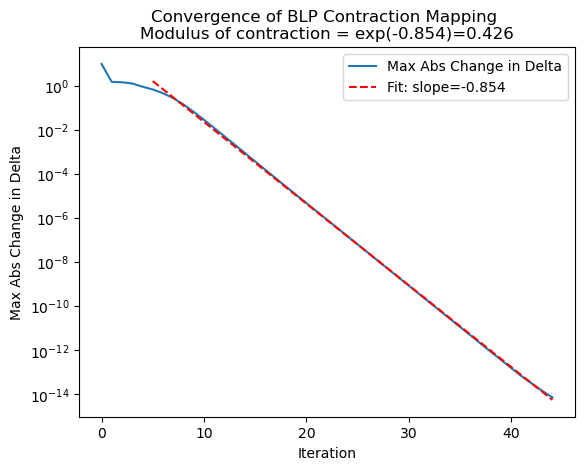

In [10]:
# Solve for delta, store errors and plot iterations on log scale
delta_hat, errors = solve_sa(contraction_logit, delta_init, verbose='notfy', tol=1e-14, maxiter=200, out='all')   
plot_convergence(errors)

## **Understanding Convergence in BLP Contraction Mapping**

### **Contraction Mapping Property**
A function $ \Gamma(\delta) $ is a **contraction mapping** if there exists a constant $ A $ (the **modulus of contraction**) such that:

$$
\|\Gamma(\delta') - \Gamma(\delta)\| \leq A \|\delta' - \delta\|, \quad \text{for some } A < 1.
$$

This property ensures that each iteration **shrinks the difference** between successive values of $ \delta $, leading to **convergence to a unique fixed point**.

### **Interpreting the Convergence Rate**
- From the log-scale error plot, the **slope** of the linear fit estimates the **rate of convergence**.
- The **modulus of contraction** is given by:

  $$
  A = \exp(\text{slope}) = \exp(-0.85) = 0.42
  $$

### **Some  Takeaways**
- For BLP we always have $ A < 1 $, so the mapping is a **contraction**, guaranteeing convergence.
- Each iteration **shrinks the error** by **$ 42\% $** compared to the previous iteration.
- A **lower $ A $** means **faster convergence**, while a **higher $ A $** (closer to 1) implies **slower convergence**.
- If $ A \geq 1 $, the contraction property fails, and convergence is **not guaranteed**.

This confirms that the **exponential decay in error** aligns with the contraction mapping theory and validates the efficiency of the iterative BLP estimation.

##  **What Determines Convergence Rate in BLP?**
To estimate $\delta$, we solve for the fixed point of the mapping:
$$
\Gamma(\delta) = \delta + \log(\hat{s}_{jt}) - \log(s_{jt}(\delta))
$$
A function $\Gamma(\delta)$ is a **contraction** if there exists $A < 1$ such that:
$$
\|\Gamma(\delta') - \Gamma(\delta)\| \leq A \|\delta' - \delta\|
$$
This guarantees **unique convergence** by shrinking differences between iterations.


- **BLP always has $A < 1$**, ensuring convergence under standard conditions.
- $A$ depends on the sensitivity of market shares to changes in $\delta$.
- **Low substitution** across products $\Rightarrow$ faster convergence (small $A$).
- **High substitution** (near-perfect substitutes) $\Rightarrow$ slower convergence (large $A$).
- The presence of a large outside good share **helps ensure contraction**.


## Veryfy that predicted market shares equals observed market shares at our solution of $\delta$

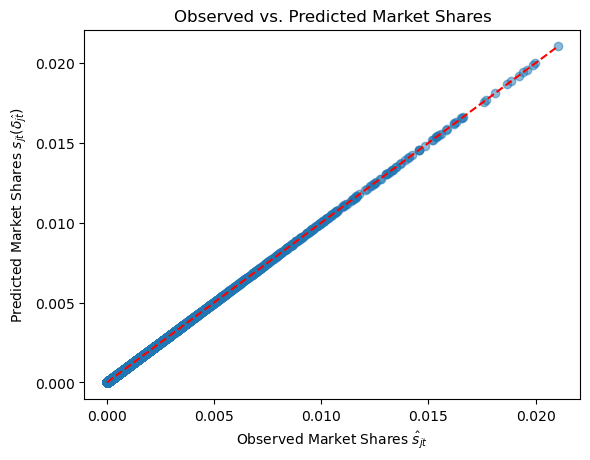

In [11]:
# Compute predicted market shares using estimated delta
s_jt_pred = predicted_share_logit(df, delta_hat)

# Scatter plot: Observed vs. Predicted market shares
plt.scatter(df["s_jt"], s_jt_pred, alpha=0.5)
plt.plot([0, max(df["s_jt"])], [0, max(df["s_jt"])], 'r--')  # 45-degree line
plt.xlabel(r"Observed Market Shares $\hat{s}_{jt}$")
plt.ylabel(r"Predicted Market Shares $s_{jt}(\delta_{\hat{jt}})$")
plt.title(r"Observed vs. Predicted Market Shares")
plt.show()

## **Contraction Mapping Finds $\delta$**
- We solve for $\delta$ using **successive approximations** on the BLP contraction:
  $$
  \delta_{jt}^{k+1} = \delta_{jt}^{k} + \log(\hat{s}_{jt}) - \log(s_{jt}(\delta^k))
  $$
- When initialized at **zero**, the contraction mapping converges to the correct $\delta$.
- When initialized at **log differences of market shares** (the solution), it converges in **one iteration**.
- The **scatter plot** of observed vs. predicted shares aligns along the **45-degree line**, verifying our implementation.

## **Part 3**: Estimate $\beta$ using GMM with $\delta$ from Contraction Mapping and compare to IV


## Moment conditions and GMM Objective

The **moment conditions** in the GMM estimation are given by:

$$
\mathbb{E}[\xi_{jt} z_{jt}] = 0, \quad \text{where } \xi_{jt} = \delta_{jt} - X_{jt} \beta
$$

The corresponding **sample moment conditions** are:

$$
g(\beta) = \frac{1}{N} Z' \xi = \frac{1}{N} Z' (\delta - X \beta)
$$

The **GMM objective estimator** minimizes the weighted quadratic form of the moments:

$$
Q(\beta) = g(\beta)' W g(\beta)
$$

where \( W \) is a positive definite weighting matrix.

In [12]:
# Compute GMM moment conditions
def gmm_moments(theta, X, Z, delta):
    """ Compute moment conditions g(β) = (Z' ξ) / N """
    theta=theta.reshape(-1, 1) # ensure that theta is Kx1
    xi = delta - X @ theta  # Structural error term (N, 1)
    g = (Z.T @ xi) / len(delta)  # Moment conditions (q, 1)
    return g

# Compute the GMM objective function g' W g (returns scalar)
def gmm_objective(theta, X, Z, delta, W):
    """ Compute the GMM objective function g' W g """
    g = gmm_moments(theta, X, Z, delta)  # (q, 1)
    return (g.T @ W @ g).item()  # Ensure scalar output

## GMM estimation

In [13]:
# Convert pandas DataFrame/Series to NumPy arrays
def pd_to_arrays(vars):
    return [var.to_frame().values if isinstance(var, pd.Series) else var.values for var in vars]

# Construct matrices X (regressors) and Z (instruments)
def build_X_Z(X1, X2, Ze):
    X1, X2, Ze = [pd.DataFrame(var) for var in [X1, X2, Ze]]
    X = pd.concat([X2, X1], axis=1)  # Combine X1 and X2 (n x k)
    Z = pd.concat([X1, Ze], axis=1)  # Combine X2 and Ze (n x q)
    return pd_to_arrays([X, Z])  # Convert to NumPy arrays

# Estimate parameters using GMM
def gmm_estimate(X1, X2, Ze, delta, verbose=True):
    """ Estimate beta using GMM """
    X, Z = build_X_Z(X1, X2, Ze)

    # Define W using the correct dimension
    W = np.eye(Z.shape[1])  

    # Ensure `W` is square
    assert W.shape == (Z.shape[1], Z.shape[1]), f"Weighting matrix W must be square, got {W.shape}"

    # Initial estimate using OLS
    beta_ols = inv(X.T @ X) @ X.T @ delta  
    
    # Estimate beta_hat using "2SLS" formula: β = (X'PzX)^(-1) * X'Pz*y
    Pz = Z @ inv(Z.T @ Z) @ Z.T  # (n x n) projection matrix (to get X predicted by Z)
    X_hat = Pz @ X  # (n x k2)    
    beta_2sls = inv(X.T@Pz@X) @ X.T@Pz@delta  # (k1 + k2 x 1)

    beta_init=beta_ols
    
    # Optimize GMM objective function
    start_time = time.perf_counter()
    res = opt.minimize(gmm_objective, beta_init.flatten(), args=(X, Z, delta, W),
                       method='BFGS', options={'disp': verbose})
    end_time = time.perf_counter()

    # Display timing
    if verbose:
        print(f"Optimization completed in {end_time - start_time:.6f} seconds")

    return res.x.reshape(-1,1), res

## Extract relevant variables and estimate model using non-linear GMM, OLS and IV

In [14]:
# Extract relevant variables and estimate model using non-linear GMM, OLS and IV
X2 = df[["price"]]  # Endogenous regressor: price
X1 = df[["const"]]  # Exogenous variables (e.g., constant term)
X1 = df[["const"] + X_var + D_type + D_year + D_make]  # Exogenous variables
X1 = df[["const"]]  # Exogenous variables
#X1 = df[["const"] + X_var]  # Exogenous variables
Ze = df[["RXR"]]  # External instruments
delta = delta_hat  # Estimated delta from contraction
df['delta']=delta_hat

# Run GMM estimation
beta_hat_gmm, res_gmm = gmm_estimate(X1, X2, Ze, delta)

# Display results
np.set_printoptions(precision=4, suppress=True, floatmode='maxprec_equal')
print("\nEstimated β_price using GMM:", beta_hat_gmm[0].T)

m2sls=mlr.tsls(y=df['delta'], X1=X1, X2=X2, Ze=Ze, robust=True)
m2ols=mlr.ols(df['delta'], pd.concat([X2, X1], axis=1), robust=True)

mlr.summary([m2ols, m2sls], column_titles=['OLS', 'IV'], print_regressors=["price" ,'const'] + X_var)
# mlr.summary([m2ols, m2sls], column_titles=['OLS', 'IV'])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization completed in 0.005359 seconds

Estimated β_price using GMM: [-0.0975]
                          OLS         IV
Dependent variable    [delta]    [delta]
             price    -0.0373    -0.0975
                     (0.0010)   (0.0040)
             const    -5.9072    -3.7399
                     (0.0426)   (0.1428)
         R_squared     0.1062    -0.1693
               TSS 37300.6952 37300.6952
               RSS 33339.4749 43617.0537
               ESS  3961.2203 -6316.3585
                 n       9694       9694
Note: Standard errors are reported in parentheses.
Only showing subset of regressors.




## Part 4: **Introduce Heterogeneity in Preferences and solve for $\delta$** given $\Sigma$
1. Adding Random Coefficients
2. Simulating Random Variables 
3. Computing Market Shares with Random Coefficients with heteroneity parameter $\Sigma$
4. Modify Contraction Mapping for $\delta$ and sove for fixed point

**NEXT**: Estimate $\beta$ and $\Sigma$ using GMM 
1. Joint estimation (burdensome)
2. Concentrating Out $X$ in GMM Estimation

## **Random Coefficients Logit (RCL)**  
RCL introduces **preference heterogeneity**, allowing substitution patterns to depend on individual-specific tastes.

### **Aggregate Market Shares**  
Heterogeneity enters through individual-specific deviations from mean preferences:  
$$
\mu_{ijt}^{(r)} = X_{jt} \Sigma \nu_{it}^{(r)}, \quad \nu_{it}^{(r)} \sim \mathcal{N}(0, I), \quad r = 1, \dots, R
$$  
where the deterministic part $X_{jt} \beta$ is already absorbed into $\delta_{jt}$. Market shares are given by:  
$$
s_{jt} = \int \frac{\exp(\delta_{jt} + X_{jt} \Sigma \nu_{it})}{1 + \sum_{k} \exp(\delta_{kt} + X_{kt} \Sigma \nu_{it})} \,\mathrm{d}F(\nu_{it})
$$  

### **Computational Approach**  
- No closed-form solution $\rightarrow$ **Monte Carlo integration**.  
- Draw $\nu_{it}^{(r)} \sim \mathcal{N}(0, I)$, compute:  
  $$
  s_{jt} \approx \frac{1}{R} \sum_{r=1}^{R} \frac{\exp(\delta_{jt} + X_{jt} \Sigma \nu_{it}^{(r)})}{1 + \sum_{k} \exp(\delta_{kt} + X_{kt} \Sigma \nu_{it}^{(r)})}
  $$  
- Use **Quasi-Monte Carlo (QMC)** methods (e.g., **Sobol**, **Halton**) for improved accuracy.

### Simulating $K\times R\times T$ array of Normal Random Varibles for Monte Carlo (MC) or quasi-Monte Carlo (QMC)

In [15]:
# !pip install chaospy # uncomment to install chaospy (or use 'random' draws only)
import chaospy  ## needs installation
import numpy as np
from scipy.stats import norm

def sim_rand(R=1000, K=1, T=1, rule='random', seed=None):
    """
    Generate Standard Normal Monte Carlo draws for random coefficients with time-specific variation.

    Parameters:
        R: Number of draws (simulated individuals).
        K: Number of random coefficients.
        T: Number of time periods.
        rule: Type of draws ("random", "halton", "sobol"])).
        seed: Random seed for reproducibility.

    Returns:
        draws: (K x R x T) array of Monte Carlo draws.
    """
    if seed is not None: 
        np.random.seed(seed)  # Ensure reproducibility
    
    if rule == 'random':
        draws = np.random.randn(K, R, T)  # (K x R x T)
    else: 
        d = K * T  # Total dimensions
        distribution = chaospy.Iid(chaospy.Uniform(0, 1), d)

        # Generate quasi-random samples (Sobol, Halton, etc.)
        u = chaospy.generate_samples(order=R, domain=distribution, rule=rule)  # (R x K*T)

        # Transform to standard normal
        draws = norm.ppf(u)  # (R x K*T)

        # Reshape to (K, R, T)
        draws = draws.T.reshape(K, R, T)  

    return draws

# Example Usage
T = df["year"].nunique()  # Number of unique years

# Simulate normal draws
draws = sim_rand(R=100, K=1, T=T, seed=42, rule='random')  # (K x R x T)


### Simulating Aggregate Market Shares
$$
s_{jt} =s_{jt}(\delta_t)= \approx \frac{1}{R} \sum_{r=1}^{R} \frac{\exp(\delta_{jt} + X_{jt} \Sigma \nu_{it}^{(r)})}{1 + \sum_{k} \exp(\delta_{kt} + X_{kt} \Sigma \nu_{it}^{(r)})}
$$
where $\nu_{it}^{(r)} \sim \mathcal{N}(0, I)$ is drawn once and fixed for estimation and $\delta$-contraction.

In [16]:
def predicted_share_rcl(df, delta, sigma, rand_vars, draws):
    """
    Compute predicted market shares using the mixed logit model with time-specific draws.
    
    Parameters:
        df: DataFrame containing product data.
        delta: Mean utility delta (N x 1).
        sigma: (K x K) covariance matrix of random coefficients.
        rand_vars: List of variable names in df for which random coefficients are used.
        draws: (K x R x T) matrix of standard normal draws for each time period.
        
    Returns:
        s_jt: (N x 1) predicted market shares.
    """
    N = len(df)  # Number of observations (products over all markets)
    R, K, T = draws.shape  # Unpack draw dimensions
    s_jt = np.zeros((N, 1))  # (N x 1)
    
    years = df["year"].unique()
    for t, year in enumerate(years):
        iy = df["year"] == year
        J_t = iy.sum()  # Number of products in this market
        
        # Extract product attributes for this market and compute random coefficients
        X_rand = df.loc[iy, rand_vars].values   # (J_t x K)        
        beta_r = X_rand @ (sigma @ draws[:, :, t])  # (K x R)
        
        # Compute logit probabilities with heterogeneous coefficients
        delta_y = delta[iy].reshape(1, -1)  # (1 x J_t)
        v = delta_y + beta_r.T  # (R x J_t)
        p_ijt = logit(v, v0=0)  # (R x J_t)
        
        # Average over Monte Carlo draws (integrating over distribution)
        s_jt[iy, 0] = np.mean(p_ijt, axis=0)  # (J_t x 1)

    return s_jt  # (N x 1)

### Solving for $\delta$ using the BLP Contraction for a given value of $\Sigma$
Given observed shares $\hat{s}_{jt}$, we solve for $\delta$ using successive approximations:
$$
\delta^{(k+1)} = \Gamma(\delta^{(k)}) = \delta^{(k)} + \log \hat{s}_{jt} - \log s_{jt}(\delta^{(k)}, \Sigma)
$$
- $s_{jt}(\delta, \Sigma)$ is now computed using the mixed logit model.
- Initialize $\delta$ using $\log (\hat{s}_{jt}/\hat{s}_{0t})$ and iterate until convergence.

### Try changing $\Sigma$ and inspect convergence properties

Solving fixed point using successive approximations
Convergence achieved after 28 iteration(s)
||x1-x0||= 9.17613e-11 <tol=1e-10



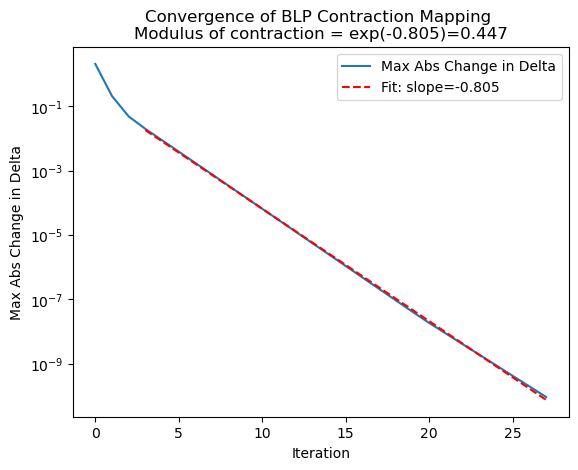

In [17]:
sigma = np.array([[0.02]])  # Standard deviation of random coefficient (e.g., price)
s_jt_hat = df[["s_jt"]].values  # (N x 1) Observed market shares
delta_init = df[["dlogs_jt"]].values  # (N x 1) Initial guess for delta

# Define contraction mapping for RCL
def contraction_rcl(delta):
    return blp_contraction(delta, s_jt_hat, 
                           lambda d: predicted_share_rcl(df, d, sigma, ["price"], draws))

# Solve for delta using successive approximations
delta_rcl, errors_rcl = solve_sa(contraction_rcl, delta_init, out='all', tol=1e-10)
plot_convergence(errors_rcl) # Plot convergence

### Plotting tool - with binscatter

In [18]:
def plot_with_reg_and_binscatter(data, x, y, xlabel, ylabel, ax=None, bins=20):
    if ax is None:
        ax = plt.gca()
    
    # Scatterplot with data
    sns.scatterplot(data=data, x=x, y=y, alpha=0.3, ax=ax)
    
    # plot regressionsline
    sns.regplot(data=data, x=x, y=y, scatter=False, color='blue', line_kws={"linestyle": "--"}, ax=ax)
    
    # Compute slope for regression line
    slope = np.polyfit(data[x].dropna(), data[y].dropna(), 1)[0]
    
    # Add titles
    ax.set_title(f'{y} vs {x} \n(Hældning: {slope:.2f})')
    
    # Binscatter-plot
    data = data[[x, y]].dropna()
    data['bin'] = pd.cut(data[x], bins=bins, include_lowest=True)
    bin_means = data.groupby('bin', observed=True)[x].mean()
    bin_values = data.groupby('bin', observed=True)[y].mean()
    ax.scatter(bin_means, bin_values, color='red', s=50, label='Binscatter')
    
    # Add labels og grid
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

### Plot delta (for given $\Sigma$) againt price (still endogenous and no other controls)
Next step $\beta$ and $\Sigma$ using GMM

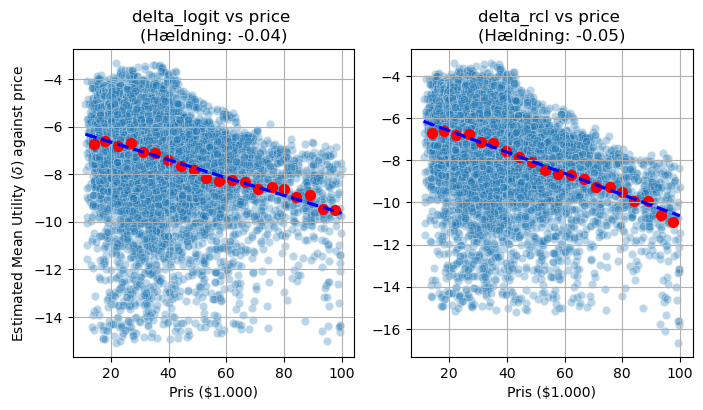

In [19]:
# Compare delta for logit and rcl
df["delta_logit"] = solve_sa(contraction_logit, delta_init, verbose='notfy')   
df["delta_rcl"]   = solve_sa(contraction_rcl, delta_init, verbose='notfy') 
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_with_reg_and_binscatter(df, 'price', 'delta_logit', 'Pris ($1.000)', r'Estimated Mean Utility ($\delta$) against price', ax=axes[0])
plot_with_reg_and_binscatter(df, 'price', 'delta_rcl', 'Pris ($1.000)', r'', ax=axes[1])

## Part 5: Estimate  $\Sigma$ using GMM
Estimate $\beta$ and $\Sigma$ using GMM 
1. Joint estimation (burdensome)
2. Concentrating Out $X$ in GMM Estimation

With only RXR as indstrument for price
- We have a *just identified system* for the pure logit $\rightarrow$ GMM criteron is 0 in optimum
- Without addtitional instruments $\beta$ and $\Sigma$ are unidentified
- Need more instruments to identify $\Sigma$ (heterogeneity in prefereces)
- We will use the Gandi-Houde instruments

## Gandhi-Houde Instruments for Preference Heterogeneity

Gandhi & Houde (2022) construct instruments based on **competitive proximity**:
- Idea: Consumers substitute more within **similar products**.
- Approach: Count nearby competitors in **key characteristics**.

### GH Instrument Definition
For each product $ j $ in market $ t $:
$$
\text{GH}_{jt}^{(c)} = \sum_{k \neq j} \mathbb{1} \left( |x_{jt}^{(c)} - x_{kt}^{(c)}| < \sigma_{t}^{(c)} \right)
$$
where $ x_{jt}^{(c)} $ is a characteristic, and $ \sigma_{t}^{(c)} $ is its standard deviation.

### Implementation
- Normalize characteristics per year.
- Count competitors within **one standard deviation**.

### Instruments Used
- We construct **one instrument per characteristic**:
$ \text{GH}_{jt}^{\text{log_height}} $, $ \text{GH}_{jt}^{\text{log_footprint}} $, $ \text{GH}_{jt}^{\text{log_hp}} $, $ \text{GH}_{jt}^{\text{log_mpg}} $, $ \text{GH}_{jt}^{\text{log_weight}} $
- Combined with **RXR (instrument for price)** to identify **$\Sigma$ (preference heterogeneity)**.


### Gandhi-Houde instruments

In [20]:
def gh_iv(df, characteristics):
    df_iv = df.copy()  # Opret en kopi for at undgå ændringer i originalen
    
    for char in characteristics:
        # Normaliser karakteristikken inden for hvert år
        df_iv[char] = df_iv.groupby('year')[char].transform(lambda x: x / x.std())
        
        # Beregn antallet af biler tæt på hver bils karakteristika
        df_iv[f'gh_iv_{char}'] = df_iv.groupby('year').apply(
            lambda group: group[char].apply(lambda x: ((group[char] - x).abs() < group[char].std()).sum())
        ).reset_index(level=0, drop=True)

    return df_iv[[f'gh_iv_{char}' for char in characteristics]]  # Returner kun instrumentkolonnerne


# Define characteristics for instruments
characteristics = ['log_height', 'log_footprint', 'log_hp', 'log_mpg', 'log_weight']

# Generate BLP and Gandhi-Houde instruments as separate DataFrames
Ze_RXR = df[["RXR"]]
Ze_gh = gh_iv(df, characteristics)
Ze_RXR_gh= pd.concat([Ze_RXR, Ze_gh], axis=1)

### GMM as function of $\Sigma$ - Concentrate out X using 2SLS

In [21]:
# Function to compute moment conditions g(Σ)
def gmm_objective_sigma(Sigma_vec, Z, W, P_S2SLS, predicted_share, delta_init, tol=1e-10, maxiter=1000, verbose='notify'):
    """
    Compute the GMM objective function Q(Σ) = g' W g 
    with momment conditions g(Σ) = (Z' ξ(Σ)) / N.
    Parameters:
        Sigma: Scalar or (K x K) covariance matrix.
        X: (N x K) matrix of regressors.
        Z: (N x Q) matrix of instruments.
        contraction_mapping: Function to solve for δ(Σ).
        delta_init: Initial guess for δ.

    Returns:
        GMM criteron: Scalar
    """
    Sigma=np.diag(np.array(Sigma_vec))  # assume Sigma is diagonal matrix
    # Solve for δ(Σ) using fixed point iteration
    contraction = lambda delta: blp_contraction(delta, s_jt_hat, lambda delta: predicted_share(delta, Sigma))
    delta = solve_sa(contraction, delta_init, tol=tol, maxiter=maxiter, verbose=verbose)
    N=len(delta) 
    
    # Project delta onto X using IVs Z (2SLS)
    beta =P_S2SLS  @  delta  # Concentrated out β(Σ)
    xi_sigma = delta - X @ beta  # Structural error term
    g = (Z.T @ xi_sigma)/N  # Moment conditions
    J=(g.T @ W @ g).item() # GMM criterion - to be minimized over Sigma
    print(f'beta_price={beta[0]}, sigma={Sigma}, GMM(Sigma)={J}')
    return J

### Evaluate Set up instruments and evaluate GMM criterion for a given value $\Sigma$

In [22]:
# Number of unique years
T = df["year"].nunique()  

# Initial delta guess (from logit estimate)
delta0 = df[["dlogs_jt"]].values  

# Simulate normal draws
draws = sim_rand(R=200, K=1, T=T, seed=42, rule='sobol')  # (K x R x T)

# Define endogenous and exogenous variables
X1=df[["const"] + X_var + D_type + D_year + D_make] # Exogenous variables
X2 = df[["price"]]  # Endogenous regressor: price
Ze = Ze_RXR_gh      # Price and GH instruments
# Ze = df[["RXR"]]    # UNCOMMENT TO TRY only price instrument - what is GMM criterion, why, and is that a problem

# Construct matrices X (regressors) and Z (instruments) and build 2SLS prjection matrix
X, Z = build_X_Z(X1, X2, Ze)
N=len(df)
P_Z = Z @ inv(Z.T @ Z) @ Z.T # Project X onto Z
P_S2SLS = inv(X.T @ P_Z @ X) @ X.T @ P_Z # 2SLS projection to be muliplied to delta to obtain beta_2sls
W=inv(Z.T@Z/N) # Weigting matrix: Inverse of Z'Z/N
 
# Try to evaluate GMM criterion for given Sigma0
Sigma0 = 0.05
# predicted shares from RCL, s_jt(delta,Sigma), as function of Sigma and delta
pred_ccp = lambda delta, Sigma: predicted_share_rcl(df, delta, Sigma, ["price"], draws)
# gmm objective
gmm_obj = lambda Sigma: gmm_objective_sigma([Sigma], Z, W, P_S2SLS, pred_ccp, delta0)
J=gmm_obj(Sigma0)

beta_price=[-0.11], sigma=[[0.05]], GMM(Sigma)=0.009051392855332525


### Plot GMM criterion against $\Sigma$
- What is our estimate of Sigma

beta_price=[-0.025], sigma=[[0.]], GMM(Sigma)=0.013132856550943662
beta_price=[-0.0316], sigma=[[0.0111]], GMM(Sigma)=0.012611872164094626
beta_price=[-0.0488], sigma=[[0.0222]], GMM(Sigma)=0.011436661077213745
beta_price=[-0.0716], sigma=[[0.0333]], GMM(Sigma)=0.010234646912830339
beta_price=[-0.0969], sigma=[[0.0444]], GMM(Sigma)=0.009345111719034065
beta_price=[-0.1233], sigma=[[0.0556]], GMM(Sigma)=0.00886295030202243
beta_price=[-0.1502], sigma=[[0.0667]], GMM(Sigma)=0.008806959444551921
beta_price=[-0.1776], sigma=[[0.0778]], GMM(Sigma)=0.009188732383641172
beta_price=[-0.2053], sigma=[[0.0889]], GMM(Sigma)=0.01002479016186375
beta_price=[-0.2333], sigma=[[0.1]], GMM(Sigma)=0.011334206099811665


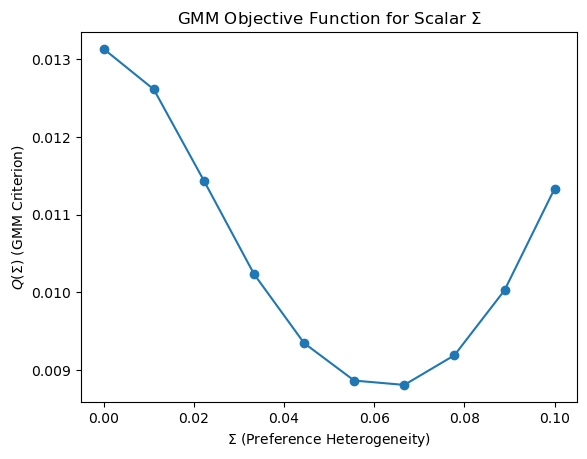

In [23]:
# Evaluate Q(Σ) over a grid of Sigma values
Sigma_vals = np.linspace(0.00, 0.1, 10)  # Range of preference heterogeneity
Q_vals = [gmm_obj(s) for s in Sigma_vals]

# Plot the GMM Criterion Function
plt.plot(Sigma_vals, Q_vals, marker='o')
plt.xlabel(r'$\Sigma$ (Preference Heterogeneity)')
plt.ylabel(r'$Q(\Sigma)$ (GMM Criterion)')
plt.title(r'GMM Objective Function for Scalar $\Sigma$')
plt.show()

### Minimize GMM criterion

In [24]:
# Initial guess of Sigma
rand_vars=["price"];  Sigma0 = np.array([0.05]); 
#rand_vars=["price", "log_hp"]; Sigma0 = np.array([0.05, 0.05]);

K=len(Sigma0)
draws = sim_rand(R=200, K=K, T=T, seed=42, rule='sobol')  # (K x R x T)
pred_ccp = lambda delta, Sigma: predicted_share_rcl(df, delta, Sigma, rand_vars, draws)
# gmm objective
gmm_obj = lambda Sigma: gmm_objective_sigma(Sigma , Z, W, P_S2SLS, pred_ccp, delta0)
J=gmm_obj(Sigma0)
res = opt.minimize(gmm_obj, Sigma0.flatten(), method='BFGS', tol=1e-8)
sigma_hat=res.x
print(res)

beta_price=[-0.11], sigma=[[0.05]], GMM(Sigma)=0.009051392855332525
beta_price=[-0.11], sigma=[[0.05]], GMM(Sigma)=0.009051392855332525
beta_price=[-0.11], sigma=[[0.05]], GMM(Sigma)=0.009051392208010307
beta_price=[-0.2168], sigma=[[0.0934]], GMM(Sigma)=0.010502923787655544
beta_price=[-0.2168], sigma=[[0.0934]], GMM(Sigma)=0.010502925484288855
beta_price=[-0.1399], sigma=[[0.0624]], GMM(Sigma)=0.008777398580243987
beta_price=[-0.1399], sigma=[[0.0624]], GMM(Sigma)=0.008777398573963929
beta_price=[-0.1402], sigma=[[0.0626]], GMM(Sigma)=0.008777373225525865
beta_price=[-0.1402], sigma=[[0.0626]], GMM(Sigma)=0.00877737322560822
beta_price=[-0.1402], sigma=[[0.0626]], GMM(Sigma)=0.00877737322120386
beta_price=[-0.1402], sigma=[[0.0626]], GMM(Sigma)=0.00877737322120395
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00877737322120386
        x: [ 6.256e-02]
      nit: 3
      jac: [ 6.054e-09]
 hess_inv: [[ 2.855e-01]]
     nfev: 10
     njev: 5


### Compute standard errors

In [25]:
import numdifftools as nd

# Compute Hessian at estimated Sigma
hessian_func = nd.Hessian(gmm_obj, step=1e-8)  
Hessian = hessian_func(res.x)  # Hessian at optimal value

# Compute standard error for Sigma
se_sigma = np.sqrt(np.diag(np.linalg.inv(Hessian))/len(df)
                   )
# Display results
print(f"Estimated Sigma: {res.x[:]}")
print(f"Standard Error: {se_sigma}")

beta_price=[-0.1402], sigma=[[0.0626]], GMM(Sigma)=0.00877737322120386
beta_price=[-0.1402], sigma=[[0.0626]], GMM(Sigma)=0.008777373221203909
beta_price=[-0.1402], sigma=[[0.0626]], GMM(Sigma)=0.008777373221204922
Estimated Sigma: [0.0626]
Standard Error: [0.0061]


### Putting it all together

In [26]:
def myBLP(df, market_id, exog, endog, ivs, rand_vars =['price'], dLogs="dlogs_jt", R=200):
    X1=df[exog] # Exogenous variables
    X2 = df[endog]  # Endogenous regressor: price
    Ze = df[ivs]  # Exluded instruments
    # Construct matrices X (regressors) and Z (instruments) and build 2SLS prjection matrix
    X, Z = build_X_Z(X1, X2, Ze)

    # Number of observations (Unique combinations of market and products)
    N=len(df)

    # Number of unique years /markets
    T = df[market_id].nunique()  
    
    # Number of random coefficients
    K= len(rand_vars)

    # Simulate normal draws
    draws = sim_rand(R, K, T, seed=42, rule='sobol')  # (K x R x T)

    # predicted shares from RCL, s_jt(delta,Sigma), as function of Sigma and delta
    pred_ccp = lambda delta, Sigma: predicted_share_rcl(df, delta, Sigma, rand_vars, draws)

    # Initial delta guess (from logit estimate)
    delta0 = df[dLogs].values  
    
    # Compute 2SLS projection matrices and Weighting matrix
    P_Z = Z @ inv(Z.T @ Z) @ Z.T # Project X onto Z
    P_S2SLS = inv(X.T @ P_Z @ X) @ X.T @ P_Z # 2SLS projection to be muliplied to delta to obtain beta_2sls
    W=inv(Z.T@Z/N) # Weigting matrix: Inverse of Z'Z/N - FIXME: should be variance of moment conditions
    
    # gmm objective
    gmm_obj = lambda Sigma: gmm_objective_sigma(Sigma , Z, W, P_S2SLS, pred_ccp, delta0)
    
    # minimize GMM objective
    Sigma0_vec = np.ones(K)*0.05; 
    res = opt.minimize(gmm_obj, Sigma0_vec.flatten(), method='BFGS', tol=1e-8)
    res.sigma_hat=res.x
    
    hessian_func = nd.Hessian(gmm_obj, step=1e-8)  
    Hessian = hessian_func(res.x)  # Hessian at optimal value

    # Compute standard error for Sigma
    res.se_sigma = np.sqrt(np.diag(np.linalg.inv(Hessian))/len(df)
                   )
    # Display results
    print(f"Estimated Sigma: {res.sigma_hat[:]}")
    print(f"Standard Error: {res.se_sigma}")

    return res

### Estimate using myBLP

In [27]:
# Define endogenous, exogenous variables, IVs and Random Coefficients
df[Ze_RXR_gh.columns] = Ze_RXR_gh.reindex(df.index)

exog=["const"] + X_var + D_type + D_year + D_make # List of exogenous attributes
endog = ["price"]  # List of endogenous regressors: price
ivs = Ze_RXR_gh.columns.tolist() # Price instruments (RXR) and GH instruments
market_id = "year" 

res=myBLP(df, market_id, exog, endog, ivs, rand_vars =['price', 'log_hp'], dLogs=["dlogs_jt"], R=200)
#res=myBLP(df, market_id, exog, endog, ivs, rand_vars =['price', 'log_hp'], dLogs=["dlogs_jt"], R=200)
print(res)

beta_price=[-0.1063], sigma=[[0.05 0.00]
 [0.00 0.05]], GMM(Sigma)=0.009323696281029893
beta_price=[-0.1063], sigma=[[0.05 0.00]
 [0.00 0.05]], GMM(Sigma)=0.009323695673179271
beta_price=[-0.1063], sigma=[[0.05 0.00]
 [0.00 0.05]], GMM(Sigma)=0.009323696262010796
beta_price=[-0.2014], sigma=[[0.0908 0.0000]
 [0.0000 0.0513]], GMM(Sigma)=0.010158487913960214
beta_price=[-0.2014], sigma=[[0.0908 0.0000]
 [0.0000 0.0513]], GMM(Sigma)=0.010158489157804476
beta_price=[-0.2014], sigma=[[0.0908 0.0000]
 [0.0000 0.0513]], GMM(Sigma)=0.010158487917224871
beta_price=[-0.1376], sigma=[[0.0637 0.0000]
 [0.0000 0.0504]], GMM(Sigma)=0.009044175221190862
beta_price=[-0.1376], sigma=[[0.0637 0.0000]
 [0.0000 0.0504]], GMM(Sigma)=0.00904417522054138
beta_price=[-0.1376], sigma=[[0.0637 0.0000]
 [0.0000 0.0504]], GMM(Sigma)=0.009044175206715849
beta_price=[-0.1377], sigma=[[0.0637 0.0000]
 [0.0000 0.0514]], GMM(Sigma)=0.009043229765215781
beta_price=[-0.1377], sigma=[[0.0637 0.0000]
 [0.0000 0.0514]], G

## References
- Berry, S. (1994). ["Estimating Discrete-Choice Models of Product Differentiation."](https://www.jstor.org/stable/2555829) *RAND Journal of Economics*, 25(2), 242–262.
- Berry, S., & Pakes, A. (2007). ["The Pure Characteristics Demand Model."]( https://doi.org/10.1111/j.1468-2354.2007.00459.x) *International Economic Review*, 48(4), 1193–1225.
- Berry, S., Levinsohn, J., & Pakes, A. (1995). ["Automobile Prices in Market Equilibrium."](https://www.jstor.org/stable/2171802) *Econometrica*, 63(4), 841–890.
- Berry, S., Levinsohn, J., & Pakes, A. (2004). ["Differentiated Products Demand Systems from a Combination of Micro and Macro Data: The New Car Market."](https://www.journals.uchicago.edu/doi/10.1086/379939) *Journal of Political Economy*, 112(1), 68–105.
- Berry, S., & Haile, P. (2021). ["Foundations of Demand Estimation."](https://doi.org/10.1016/bs.hesind.2021.11.001) In *Handbook of Industrial Organization* (Vol. 4), pp. 1–62.
- Conlon, C., & Gortmaker, J. (2020). ["Best Practices for Differentiated Products Demand Estimation with PyBLP."](https://doi.org/10.1111/1756-2171.12352) *RAND Journal of Economics*, 51(4), 1108–1161.
- Conlon, C., & Gortmaker, J. (2025). ["Incorporating Microdata into Differentiated Products Demand Estimation with PyBLP."](https://doi.org/10.1016/j.jeconom.2024.105926), *Journal of Econometrics*, forthcoming
- DellaVigna, S., & Gentzkow, M. (2019). ["Uniform Pricing in US Retail Chains."](https://academic.oup.com/qje/article/134/4/2011/5549382) *Quarterly Journal of Economics*, 134(4), 2011–2084.
- Hausman, J. (1996). ["Valuation of New Goods Under Perfect and Imperfect Competition."](https://www.nber.org/chapters/c6068) In *The Economics of New Goods* (University of Chicago Press), pp. 207–248.
- Nevo, A. (2000). ["A Practitioner's Guide to Estimation of Random-Coefficients Logit Models of Demand."](https://doi.org/10.1111/j.1430-9134.2000.00513.x) *Journal of Economics & Management Strategy*, 9(4), 513–548.
- Petrin, A. (2002). ["Quantifying the Benefits of New Products: The Case of the Minivan."](https://www.journals.uchicago.edu/doi/10.1086/340779) *Journal of Political Economy*, 110(4), 705–729.